## Michael Shao

In [1]:
import warnings

import matplotlib.pyplot as plt
import nest_asyncio
import numpy as np
import pandas as pd
import seaborn as sns
import stan
from mpl_toolkits import mplot3d

warnings.filterwarnings("ignore")

nest_asyncio.apply()

In [2]:
plt.rcParams.update({"figure.figsize": (12, 10)})
plt.rcParams.update({"font.size": 20})

## Data Cleaning

In [3]:
Seasons = pd.read_csv("Seasons_Stats.csv", index_col=0)

In [4]:
Seasons.shape

(24691, 52)

Remove all data before 1980. Before 1980, there is no 3 points in basketball games

Also, lots of missing data before 1874

Year: 1980 and 2017

In [5]:
Seasons = Seasons.query("Year >= 1980").reset_index(drop=True)

Drop two blank columns: blan, blank2, GS - does not help to build model

In [6]:
Seasons = Seasons.drop(columns=["blanl", "blank2", "GS"])

In [7]:
Seasons[Seasons["PER"].isna()]

,Year,Player,Pos,Age,Tm,G,MP,PER,TS%,3PAr,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
12034,2006.0,Josh Davis,PF,25.0,HOU,1.0,0.0,NaN,NaN,NaN,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
12351,2006.0,Alex Scales,SG,27.0,SAS,1.0,0.0,NaN,NaN,NaN,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13314,2008.0,Stephane Lasme,SF,25.0,GSW,1.0,0.0,NaN,NaN,NaN,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14284,2010.0,JamesOn Curry,PG,24.0,LAC,1.0,0.0,NaN,NaN,NaN,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16172,2013.0,Damion James,SF,25.0,BRK,2.0,0.0,NaN,NaN,NaN,...,NaN,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


Above 5 rows are not valid data. Drop these

In [8]:
Seasons = Seasons.dropna(subset=["ORB%"])

All these values are dependent on another value. Since those values are 0, those dependent values are 0 as well

In [9]:
Seasons["3P%"] = Seasons["3P%"].fillna(0)
Seasons["FT%"] = Seasons["FT%"].fillna(0)
Seasons["2P%"] = Seasons["2P%"].fillna(0)
Seasons["3PAr"] = Seasons["3PAr"].fillna(0)
Seasons["FTr"] = Seasons["FTr"].fillna(0)
Seasons["FG%"] = Seasons["FG%"].fillna(0)
Seasons["TS%"] = Seasons["TS%"].fillna(0)
Seasons["eFG%"] = Seasons["eFG%"].fillna(0)

TOV% Group by Pos and fill by mean

In [10]:
mean_tov = Seasons.groupby("Pos")["TOV%"].mean()

In [11]:
for index in mean_tov.index:
    Seasons.loc[
        (Seasons["TOV%"].isna()) & (Seasons["Pos"] == index),
        "TOV%",
    ] = mean_tov[index]

In [12]:
Seasons["TotalG"] = Seasons.groupby("Player")["G"].transform("sum")

In [13]:
## Get Rid of Players who only scored 0 point and player 4 games
Seasons = Seasons.query("TotalG >= 4 & PTS > 0")

In [14]:
Seasons.shape

(18611, 50)

## Models: PTS, PER (Player Efficiency Rating), WS (Wins Share - the number of wins contributed by a player)

Find PTS for each game in case if players get injured

For example, Michael Jordan only played 18 games in 1986

Not take consideration of PTS that is 0. Otherwise, LogPTS is -inf

In [15]:
Seasons["PTSPerGame"] = Seasons["PTS"] / Seasons["G"]
Seasons["LogPTSPerGame"] = np.log(Seasons["PTSPerGame"])

In [16]:
Seasons.columns

Index(['Year', 'Player', 'Pos', 'Age', 'Tm', 'G', 'MP', 'PER', 'TS%', '3PAr',
       'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%',
       'OWS', 'DWS', 'WS', 'WS/48', 'OBPM', 'DBPM', 'BPM', 'VORP', 'FG', 'FGA',
       'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA',
       'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS',
       'TotalG', 'PTSPerGame', 'LogPTSPerGame'],
      dtype='object')

In [17]:
Seasons.shape

(18611, 52)

<AxesSubplot:xlabel='PTSPerGame', ylabel='Count'>

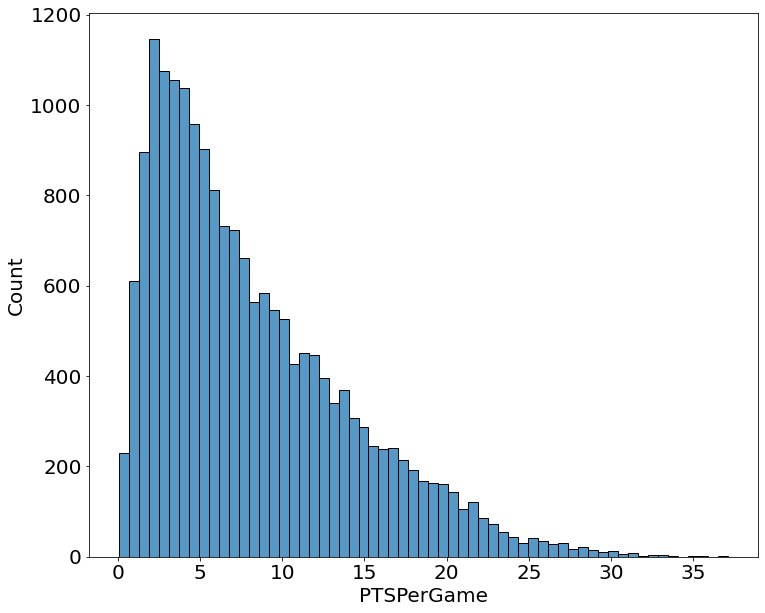

In [18]:
sns.histplot(Seasons["PTSPerGame"])
# plt.savefig("PTS")

<AxesSubplot:xlabel='PER', ylabel='Count'>

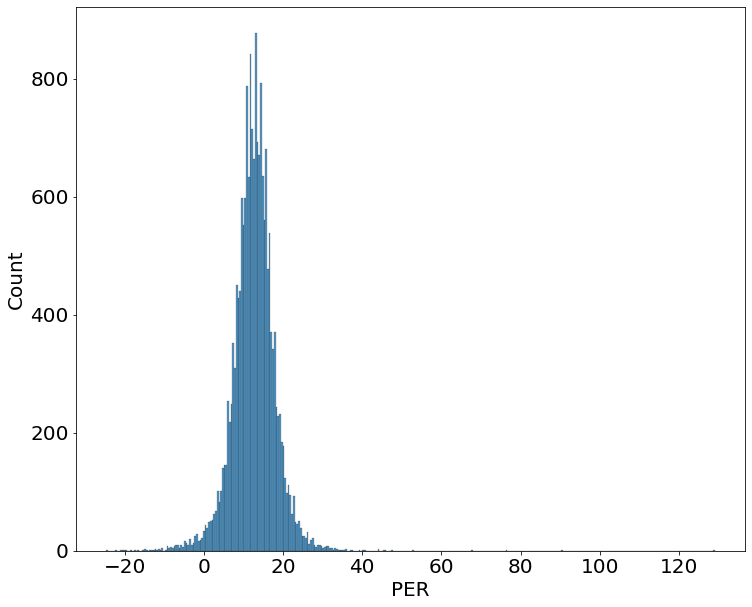

In [19]:
sns.histplot(Seasons["PER"])
# plt.savefig("PER")

<AxesSubplot:xlabel='WS', ylabel='Count'>

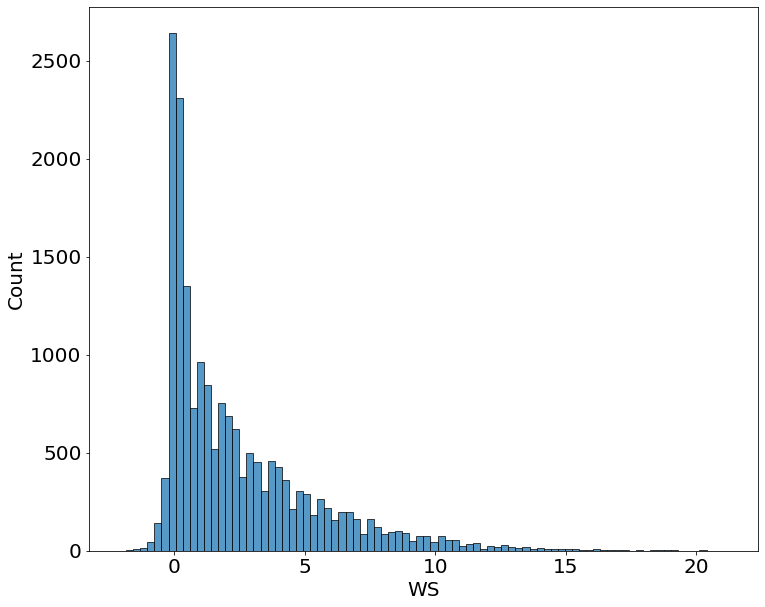

In [20]:
sns.histplot(Seasons["WS"])
# plt.savefig("WS")

In [21]:
df1 = Seasons.copy()

In [22]:
SeasonsStatsPTS = (
    df1.groupby("Player")["LogPTSPerGame"]
    .agg(["count", "mean"])
    .reset_index()
    .rename(columns={"count": "SeasonsPlayed", "mean": "AvgPTS"})
)

In [23]:
SeasonsStats = (
    df1.groupby("Player")[["PER", "WS"]]
    .mean()
    .reset_index()
    .rename(columns={"PER": "AvgPER", "WS": "AvgWS"})
)

In [24]:
SeasonsStats = SeasonsStatsPTS.merge(SeasonsStats, on="Player")

In [25]:
SeasonsStats["PlayerIndex"] = SeasonsStats.index + 1

Join back to the original dataset so it has PlayerIndex

In [26]:
dfIncl = df1.merge(SeasonsStats, on="Player", how="inner")

Ranking player based on AvgPTS, AvgPER, AvgWS

In [28]:
dfIncl[["Year", "Player", "Pos", "Age", "G", "PER", "LogPTSPerGame", "WS"]].query("Player == 'Michael Jordan*'")

,Year,Player,Pos,Age,G,PER,LogPTSPerGame,WS
3836,1985.0,Michael Jordan*,SG,21.0,82.0,25.8,3.339581,14.0
3837,1986.0,Michael Jordan*,SG,22.0,18.0,27.5,3.120895,1.5
3838,1987.0,Michael Jordan*,SG,23.0,82.0,29.8,3.613222,16.9
3839,1988.0,Michael Jordan*,SG,24.0,82.0,31.7,3.554651,21.2
3840,1989.0,Michael Jordan*,SG,25.0,81.0,31.1,3.481430,19.8
3841,1990.0,Michael Jordan*,SG,26.0,82.0,31.2,3.513727,19.0
3842,1991.0,Michael Jordan*,SG,27.0,82.0,31.6,3.448825,20.3
3843,1992.0,Michael Jordan*,SG,28.0,80.0,27.7,3.402863,17.7
3844,1993.0,Michael Jordan*,SG,29.0,78.0,29.7,3.483604,17.2
3845,1995.0,Michael Jordan*,SG,31.0,17.0,22.1,3.291470,2.3


In [138]:
SeasonsStats["RankPTS"] = SeasonsStats["AvgPTS"].rank(ascending=False)
SeasonsStats["RankPER"] = SeasonsStats["AvgPER"].rank(ascending=False)
SeasonsStats["RankWS"] = SeasonsStats["AvgWS"].rank(ascending=False)

**Find top 20 and bottom 20 scorers**

In [139]:
top20PTS = SeasonsStats.nsmallest(20, "RankPTS")
top20PTS["PTSPosition"] = "Top 20"
bottom20PTS = SeasonsStats.nlargest(20, "RankPTS")
bottom20PTS["PTSPosition"] = "Bottom 20"

In [140]:
extremespts = pd.concat([top20PTS, bottom20PTS])

In [141]:
top20PTS.columns

Index(['Player', 'SeasonsPlayed', 'AvgPTS', 'AvgPER', 'AvgWS', 'PlayerIndex',
       'RankPTS', 'RankPER', 'RankWS', 'PTSPosition'],
      dtype='object')

In [142]:
top20PTS['AvgPTS'] = round(top20PTS['AvgPTS'], 2)
bottom20PTS['AvgPTS'] = round(bottom20PTS['AvgPTS'], 2)

In [143]:
top20PTS[['Player', 'SeasonsPlayed', 'AvgPTS','RankPTS','PTSPosition']]

,Player,SeasonsPlayed,AvgPTS,RankPTS,PTSPosition
1819,Michael Jordan*,15,3.37,1.0,Top 20
1606,LeBron James,14,3.30,2.0,Top 20
1498,Kevin Durant,10,3.29,3.0,Top 20
939,George Gervin*,7,3.23,4.0,Top 20
371,Carmelo Anthony,16,3.21,5.0,Top 20
1433,Karl Malone*,19,3.19,6.0,Top 20
1580,Larry Bird*,13,3.16,7.0,Top 20
67,Allen Iverson*,20,3.14,8.0,Top 20
1539,Kobe Bryant,20,3.14,9.0,Top 20
736,Dominique Wilkins*,17,3.13,10.0,Top 20


In [144]:
bottom20PTS[['Player', 'SeasonsPlayed', 'AvgPTS','RankPTS','PTSPosition']]

,Player,SeasonsPlayed,AvgPTS,RankPTS,PTSPosition
1139,James Scott,1,-2.08,2719.0,Bottom 20
376,Casey Shaw,1,-1.50,2718.0,Bottom 20
872,Erik Murphy,1,-1.39,2717.0,Bottom 20
1273,Jim Zoet,1,-1.25,2716.0,Bottom 20
386,Cezary Trybanski,3,-1.04,2715.0,Bottom 20
1879,Miles Simon,1,-0.92,2714.0,Bottom 20
10,Aaron Harrison,2,-0.88,2713.0,Bottom 20
1998,Patrick Ewing,1,-0.85,2712.0,Bottom 20
1816,Michael Gbinije,1,-0.81,2711.0,Bottom 20
1430,Kannard Johnson,1,-0.69,2709.0,Bottom 20


**Find top 20 and bottom 20 based on PER**

In [145]:
top20PER = SeasonsStats.nsmallest(20, "RankPER")
top20PER["PERPosition"] = "Top 20"
bottom20PER = SeasonsStats.nlargest(20, "RankPER")
bottom20PER["PERPosition"] = "Bottom 20"

In [146]:
extremesper = pd.concat([top20PER, bottom20PER])

**Find top 20 and bottom 20 based on WS**

In [147]:
top20WS = SeasonsStats.nsmallest(20, "RankWS")
top20WS["WSPosition"] = "Top 20"
bottom20WS = SeasonsStats.nlargest(20, "RankWS")
bottom20WS["WSPosition"] = "Bottom 20"

In [148]:
extremesWS = pd.concat([top20WS, bottom20WS])

In [149]:
print(f'Average point is {round(SeasonsStats["AvgPTS"].mean(),2)}')
print(f'Average player efficiency rating {round(SeasonsStats["AvgPER"].mean(),2)}')
print(f'Averge win share {round(SeasonsStats["AvgWS"].mean(),2)}')

Average point is 1.48
Average player efficiency rating 11.22
Averge win share 1.53


In [150]:
SeasonsStats = (
    SeasonsStats.merge(extremespts[["Player", "PTSPosition"]], how="left", on="Player")
    .merge(extremesper[["Player", "PERPosition"]], how="left", on="Player")
    .merge(extremesWS[["Player", "WSPosition"]], how="left", on="Player")
)

Fill in Position with Middle

In [151]:
SeasonsStats = SeasonsStats.fillna("Middle")

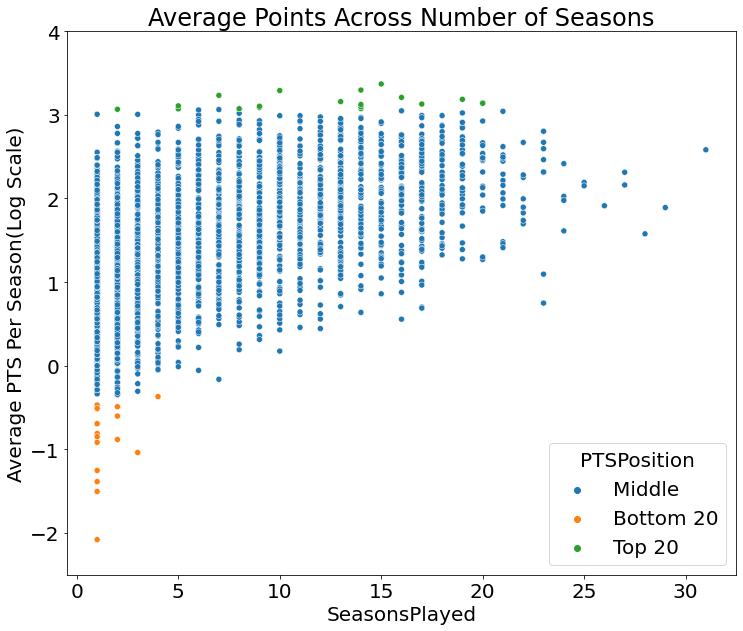

In [152]:
sns.scatterplot(data=SeasonsStats, x="SeasonsPlayed", y="AvgPTS", hue="PTSPosition")
plt.ylim(bottom=-2.5)
plt.ylim(top=4)
plt.ylabel("Average PTS Per Season(Log Scale)")
plt.title("Average Points Across Number of Seasons")
plt.savefig("PTS")

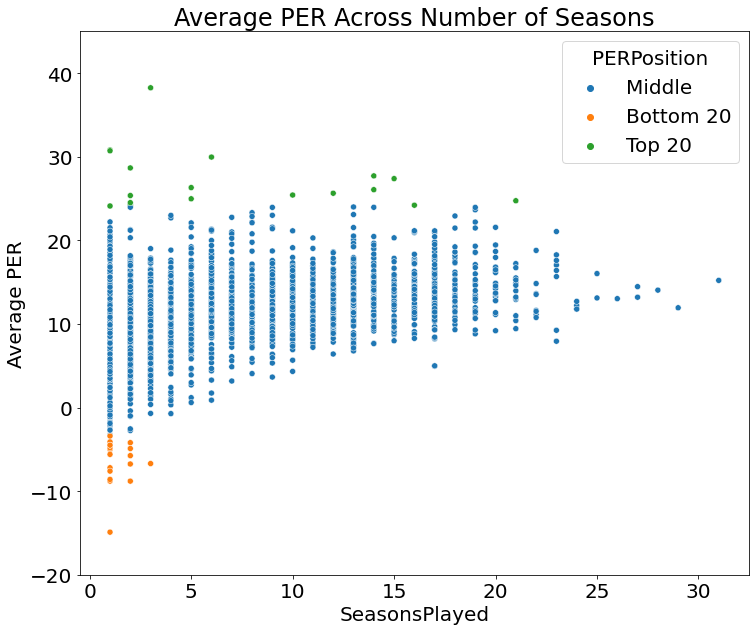

In [154]:
sns.scatterplot(data=SeasonsStats, x="SeasonsPlayed", y="AvgPER", hue="PERPosition")
plt.ylabel("Average PER")
plt.title("Average PER Across Number of Seasons")
plt.ylim(bottom=-20)
plt.ylim(top=45)
plt.savefig("PER")

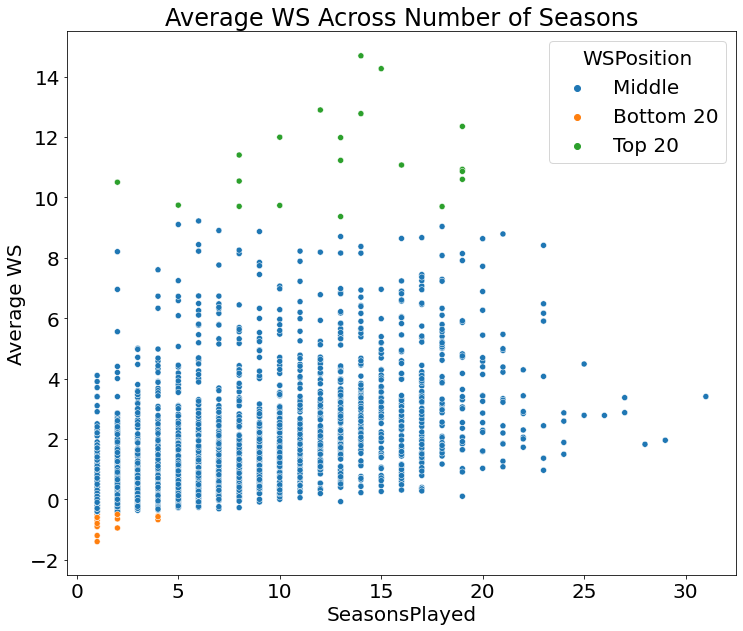

In [44]:
sns.scatterplot(data=SeasonsStats, x="SeasonsPlayed", y="AvgWS", hue="WSPosition")
plt.ylim(bottom=-2.5)
plt.ylim(top=15.5)
plt.ylabel("Average WS")
plt.title("Average WS Across Number of Seasons")
plt.savefig("WS")

In [45]:
nObs = dfIncl.shape[0]  # total rows
nPlayers = SeasonsStats.shape[0]  # total players

**PTS Model**

In [49]:
# create data dictionary for stan model
model_dataPTS = {
    "nObs": nObs,
    "nPlayers": nPlayers,
    "PlayerID": dfIncl.PlayerIndex.values,
    "y": dfIncl.LogPTSPerGame.values,
}

In [50]:
model_codePTS = """
data {
  int<lower=0> nObs;                           // number of rows in full data 
  int<lower=0> nPlayers;                       // number of Players
  int<lower=1,upper=nPlayers> PlayerID[nObs];  // user index for each row
  vector[nObs] y;                              // PTS/Game
}

parameters {
  real<lower=0> sigma;         // sd alpha
  real mu;                     // mean alpha
  vector[nPlayers] alpha;      // user effects
  real<lower=0> sigma_y;       // sd data
}

model {
  sigma ~ cauchy(0, 2.5);
  mu ~ normal(0, 5);
  alpha ~ normal(mu, sigma);
  sigma_y ~ cauchy(0, 2);

  y ~ normal(alpha[PlayerID], sigma_y);
}
"""

In [43]:
# compile stan model
theModelPTS = stan.build(model_codePTS, data=model_dataPTS)

Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_b2iuav02/model_5ifxrevr.stan', line 5, column 2: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc


In [ ]:
fitPTS = theModelPTS.sample(num_chains=4, num_samples=1000)

**PER Model**

In [45]:
# create data dictionary for stan model
model_dataPER = {
    "nObs": nObs,
    "nPlayers": nPlayers,
    "PlayerID": dfIncl.PlayerIndex.values,
    "y": dfIncl.PER.values,
}

In [46]:
model_codePER = """
data {
  int<lower=0> nObs;                           // number of rows in full data 
  int<lower=0> nPlayers;                       // number of Players
  int<lower=1,upper=nPlayers> PlayerID[nObs];  // user index for each row
  vector[nObs] y;                              // PER
}

parameters {
  real<lower=0> sigma;         // sd alpha
  real mu;                     // mean alpha
  vector[nPlayers] alpha;      // user effects
  real<lower=0> sigma_y;       // sd data
}

model {
  sigma ~ cauchy(0, 2.5);
  mu ~ normal(0, 5);
  alpha ~ normal(mu, sigma);
  sigma_y ~ cauchy(0, 2.5);

  y ~ normal(alpha[PlayerID], sigma_y);
}
"""

In [47]:
# compile stan model
theModelPER = stan.build(model_codePER, data=model_dataPER)

Building...



Building: 89.4s, done.Messages from stanc:
Warning in '/tmp/httpstan_upkjdipf/model_3txq766b.stan', line 5, column 2: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc


In [ ]:
fitPER = theModelPER.sample(num_chains=4, num_samples=1000)

**WS Model**

In [42]:
# create data dictionary for stan model
model_dataWS = {
    "nObs": nObs,
    "nPlayers": nPlayers,
    "PlayerID": dfIncl.PlayerIndex.values,
    "y": dfIncl.WS.values,
}

In [43]:
model_codeWS = """
data {
  int<lower=0> nObs;                           // number of rows in full data 
  int<lower=0> nPlayers;                       // number of Players
  int<lower=1,upper=nPlayers> PlayerID[nObs];  // user index for each row
  vector[nObs] y;                              // WS
}

parameters {
  real<lower=0> sigma;         // sd alpha
  real mu;                     // mean alpha
  vector[nPlayers] alpha;      // user effects
  real<lower=0> sigma_y;       // sd data
}

model {
  sigma ~ cauchy(0, 2.5);
  mu ~ normal(0, 5);
  alpha ~ normal(mu, sigma);
  sigma_y ~ cauchy(0, 2.5);

  y ~ normal(alpha[PlayerID], sigma_y);
}
"""

In [44]:
# compile stan model
theModelWS = stan.build(model_codeWS, data=model_dataWS)

Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_anmrw9u5/model_fa2wbvov.stan', line 5, column 2: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc


In [ ]:
fitWS = theModelWS.sample(num_chains=4, num_samples=1000)

**Posterior Distribution**

In [ ]:
mcmcAlphaPTS = pd.DataFrame(fitPTS["alpha"])
mcmcAlphaPER = pd.DataFrame(fitPER["alpha"])
mcmcAlphaWS = pd.DataFrame(fitWS["alpha"])

In [ ]:
# mcmcAlphaPTS.to_csv("mcmcAlphaPTS.csv", index= False)
# mcmcAlphaPER.to_csv("mcmcAlphaPER.csv", index= False)
# mcmcAlphaWS.to_csv("mcmcAlphaWS.csv", index= False)

In [46]:
mcmcAlphaPTS = pd.read_csv("mcmcAlphaPTS.csv")
mcmcAlphaPER = pd.read_csv("mcmcAlphaPER.csv")
mcmcAlphaWS = pd.read_csv("mcmcAlphaWS.csv")

In [47]:
mcmcAlphaPTS["PlayerIndex"] = mcmcAlphaPTS.index + 1
mcmcAlphaPER["PlayerIndex"] = mcmcAlphaPER.index + 1
mcmcAlphaWS["PlayerIndex"] = mcmcAlphaWS.index + 1

In [48]:
alphaDrawsPTS = pd.melt(mcmcAlphaPTS, id_vars=["PlayerIndex"], value_name="alpha")
alphaDrawsPER = pd.melt(mcmcAlphaPER, id_vars=["PlayerIndex"], value_name="alpha")
alphaDrawsWS = pd.melt(mcmcAlphaWS, id_vars=["PlayerIndex"], value_name="alpha")

In [49]:
alphaDrawsPTS = alphaDrawsPTS.rename(columns={"variable": "draw"})

In [50]:
alphaDrawsPTS = alphaDrawsPTS.rename(columns={"variable": "draw"})
alphaDrawsPTS["draw"] = alphaDrawsPTS["draw"].astype("int") + 1
alphaDrawsPER = alphaDrawsPER.rename(columns={"variable": "draw"})
alphaDrawsPER["draw"] = alphaDrawsPER["draw"].astype("int") + 1
alphaDrawsWS = alphaDrawsWS.rename(columns={"variable": "draw"})
alphaDrawsWS["draw"] = alphaDrawsWS["draw"].astype("int") + 1

In [51]:
# get posterior summaries
def f(x):
    d = {}
    d["mean"] = x["alpha"].mean()
    d["q2_5"] = x["alpha"].quantile(0.025)
    d["q97_5"] = x["alpha"].quantile(0.975)
    return pd.Series(d, index=["mean", "q2_5", "q97_5"])

In [52]:
# useful when we simulate by ranking
# alphaDrawsPTS["BayesPTSRank"] = alphaDrawsPTS.groupby("draw")["alpha"].rank(
#     ascending=False
# )
# alphaDrawsPER["BayesPERRank"] = alphaDrawsPER.groupby("draw")["alpha"].rank(
#     ascending=False
# )
# alphaDrawsWS["BayesWSRank"] = alphaDrawsWS.groupby("draw")["alpha"].rank(
#     ascending=False
# )

In [53]:
alphaStatsPTS = (
    alphaDrawsPTS.groupby(["PlayerIndex"])
    .apply(f)
    .reset_index()
    .rename(columns={"mean": "BayesPTS", "q2_5": "q2_5PTS", "q97_5": "q97_5PTS"})
)

In [54]:
alphaStatsPER = (
    alphaDrawsPER.groupby(["PlayerIndex"])
    .apply(f)
    .reset_index()
    .rename(columns={"mean": "BayesPER", "q2_5": "q2_5PER", "q97_5": "q97_5PER"})
)

In [55]:
alphaStatsWS = (
    alphaDrawsWS.groupby(["PlayerIndex"])
    .apply(f)
    .reset_index()
    .rename(columns={"mean": "BayesWS", "q2_5": "q2_5WS", "q97_5": "q97_5WS"})
)

In [56]:
alphaStats = alphaStatsPTS.merge(alphaStatsPER, on="PlayerIndex").merge(
    alphaStatsWS, on="PlayerIndex"
)

In [57]:
alphaStats = SeasonsStats.merge(alphaStats, on="PlayerIndex")

In [58]:
alphaStats["BayesRankPTS"] = alphaStats["BayesPTS"].rank(ascending=False)
alphaStats["BayesRankPER"] = alphaStats["BayesPER"].rank(ascending=False)
alphaStats["BayesRankWS"] = alphaStats["BayesWS"].rank(ascending=False)

In [59]:
Bayestop20PTS = alphaStats.nsmallest(20, "BayesRankPTS")
Bayestop20PTS["BayesPositionPTS"] = "Top 20"
Bayesbottom20PTS = alphaStats.nlargest(20, "BayesRankPTS")
Bayesbottom20PTS["BayesPositionPTS"] = "Bottom 20"
BayesextremesPTS = pd.concat([Bayestop20PTS, Bayesbottom20PTS])

In [60]:
Bayestop20PER = alphaStats.nsmallest(20, "BayesRankPER")
Bayestop20PER["BayesPositionPER"] = "Top 20"
Bayesbottom20PER = alphaStats.nlargest(20, "BayesRankPER")
Bayesbottom20PER["BayesPositionPER"] = "Bottom 20"
BayesextremesPER = pd.concat([Bayestop20PER, Bayesbottom20PER])

In [61]:
Bayestop20WS = alphaStats.nsmallest(20, "BayesRankWS")
Bayestop20WS["BayesPositionWS"] = "Top 20"
Bayesbottom20WS = alphaStats.nlargest(20, "BayesRankWS")
Bayesbottom20WS["BayesPositionWS"] = "Bottom 20"
BayesextremesWS = pd.concat([Bayestop20WS, Bayesbottom20WS])

In [62]:
# Bayesextremes["DiffRanks"] = Bayesextremes["RankPTS"] - Bayesextremes["BayesRankPTS"]
# Bayesextremes

In [63]:
alphaStats = (
    alphaStats.merge(
        BayesextremesPTS[["Player", "BayesPositionPTS"]], how="left", on="Player"
    )
    .merge(BayesextremesPER[["Player", "BayesPositionPER"]], how="left", on="Player")
    .merge(BayesextremesWS[["Player", "BayesPositionWS"]], how="left", on="Player")
)

#fill in NA with Middle

In [64]:
alphaStats = alphaStats.fillna("Middle")

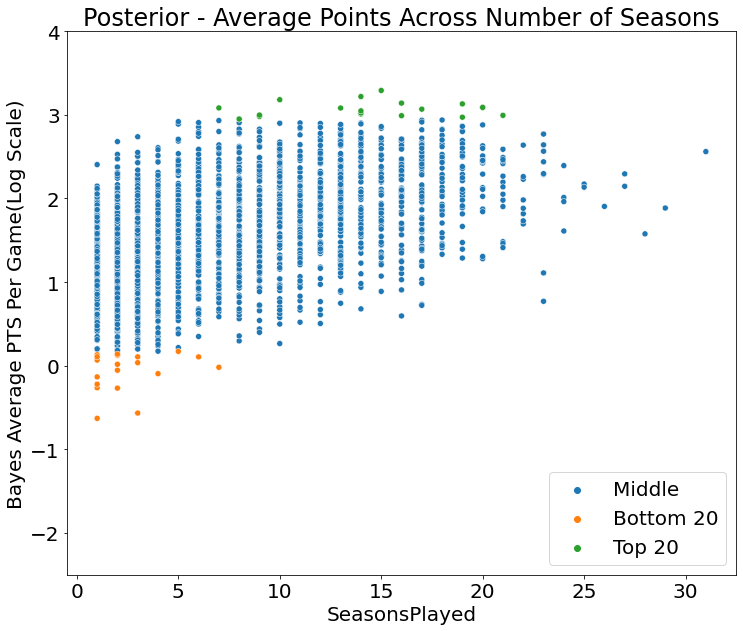

In [65]:
sns.scatterplot(
    data=alphaStats, x="SeasonsPlayed", y="BayesPTS", hue="BayesPositionPTS"
)
plt.ylim(bottom=-2.5)
plt.ylim(top=4)
plt.legend(loc="lower right")
plt.ylabel("Bayes Average PTS Per Game(Log Scale)")
plt.title("Posterior - Average Points Across Number of Seasons")
plt.savefig("bayesPTS")

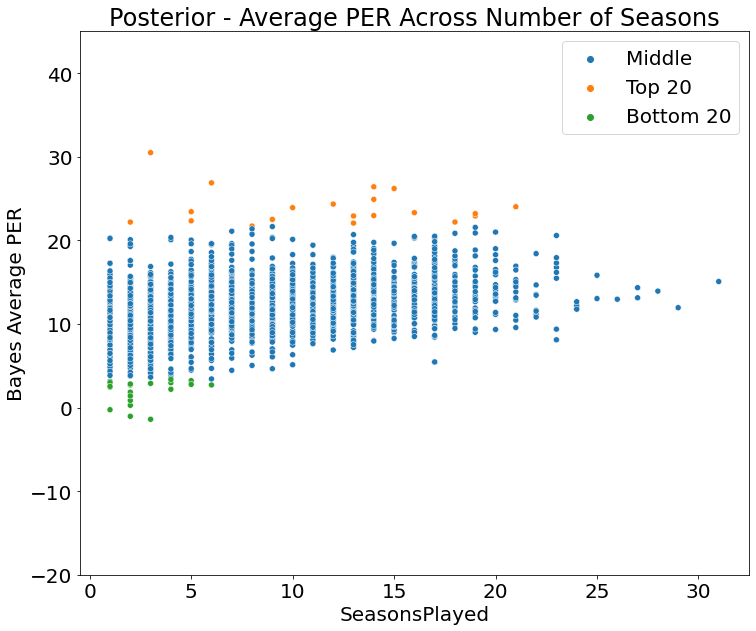

In [66]:
sns.scatterplot(
    data=alphaStats, x="SeasonsPlayed", y="BayesPER", hue="BayesPositionPER"
)
plt.ylim(bottom=-20)
plt.ylim(top=45)
plt.legend(loc="upper right")
plt.ylabel("Bayes Average PER")
plt.title("Posterior - Average PER Across Number of Seasons")
plt.savefig("bayesper")

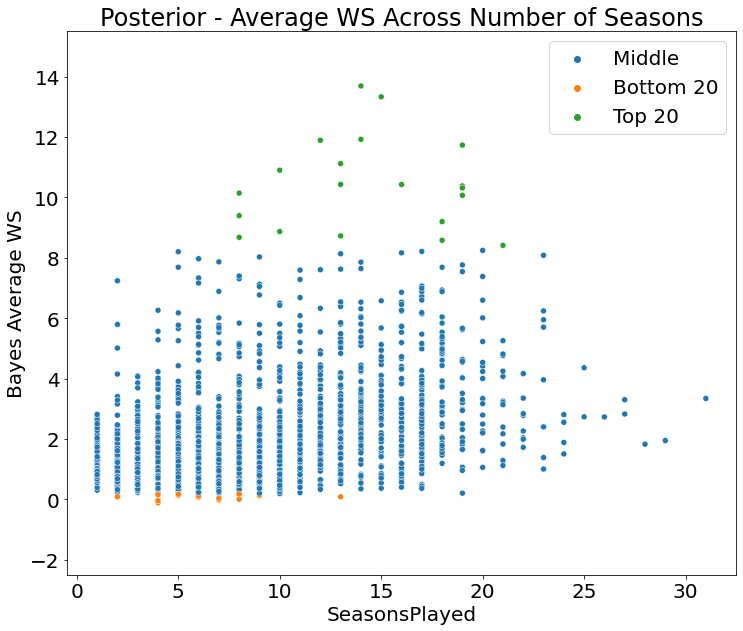

In [67]:
sns.scatterplot(data=alphaStats, x="SeasonsPlayed", y="BayesWS", hue="BayesPositionWS")
plt.ylim(bottom=-2.5)
plt.ylim(top=15.5)
plt.legend(loc="upper right")
plt.ylabel("Bayes Average WS")
plt.title("Posterior - Average WS Across Number of Seasons")
plt.savefig("bayesWS")

In [68]:
# strong correlation - calculation - not just PTS
# sns.scatterplot(alphaStats["BayesPER"], alphaStats["BayesPTS"])

In [69]:
# strong correlation - calculation - not just PTS
# sns.scatterplot(alphaStats["BayesPTS"], alphaStats["BayesWS"])

In [70]:
# sns.scatterplot(alphaStats["BayesPER"], alphaStats["BayesWS"])

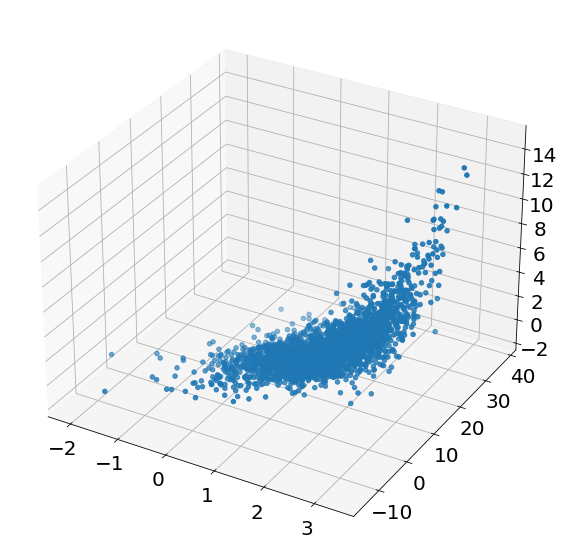

In [85]:
ax = plt.axes(projection="3d")
ax.scatter3D(alphaStats["AvgPTS"], alphaStats["AvgPER"], alphaStats["AvgWS"]);

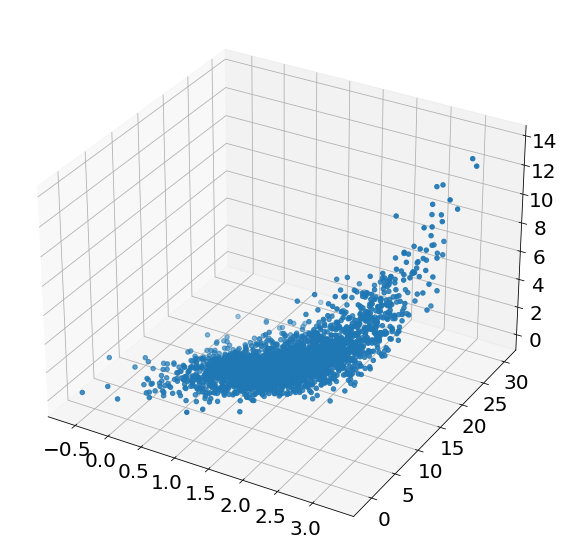

In [93]:
ax = plt.axes(projection="3d")
# ax.plot3D(xline, yline, zline, 'gray')
ax.scatter3D(alphaStats["BayesPTS"], alphaStats["BayesPER"], alphaStats["BayesWS"]);
#plt.savefig("3Dx")

In [73]:
alphaStats['BayesRankOverall'] = (alphaStats['BayesRankPTS'] + alphaStats['BayesRankPER'] + alphaStats['BayesRankWS']) / 3
alphaStats['BayesRankOver'] = (alphaStats['BayesPER'] + alphaStats['BayesWS'] + alphaStats['BayesPTS']) / 3

In [74]:
alphaStats.sort_values("BayesRankOverall")[["Player", "SeasonsPlayed", "BayesRankPTS", "BayesRankPER", "BayesRankWS"]].head(10)

,Player,SeasonsPlayed,BayesRankPTS,BayesRankPER,BayesRankWS
1606,LeBron James,14,2.0,3.0,1.0
1819,Michael Jordan*,15,1.0,4.0,2.0
1498,Kevin Durant,10,3.0,8.0,7.0
1433,Karl Malone*,19,5.0,13.0,5.0
390,Charles Barkley*,16,16.0,10.0,9.0
1580,Larry Bird*,13,9.0,19.0,8.0
632,David Robinson*,14,29.0,5.0,3.0
2340,Shaquille O'Neal*,21,15.0,7.0,20.0
445,Chris Paul,12,41.0,6.0,4.0
793,Dwyane Wade,14,11.0,12.0,30.0


**Posterior Distribution for 4 or 5 Playrs**

**All Players From 3 original and Bayes ranks**

In [75]:
top15list = [
    "Michael Jordan*",
    "LeBron James",
    "Magic Johnson*",
    "Tim Duncan",
    "Kobe Bryant",
    "Kevin Durant",
    "Hakeem Olajuwon*",
    "Julius Erving*",
    "Moses Malone*",
    "Stephen Curry",
    "Dirk Nowitzki",
    "Karl Malone",
    "Kevin Garnett",
    "Charles Barkley*",
    "Shaquille O'Neal*",
]

Used those files and rank players to see if they are team players or individual players

In [76]:
top15Players = alphaStats[alphaStats["Player"].isin(top15list)]

In [77]:
top15Players

,Player,SeasonsPlayed,AvgPTS,AvgPER,AvgWS,PlayerIndex,RankPTS,RankPER,RankWS,PTSPosition,...,q2_5WS,q97_5WS,BayesRankPTS,BayesRankPER,BayesRankWS,BayesPositionPTS,BayesPositionPER,BayesPositionWS,BayesRankOverall,BayesRankOver
390,Charles Barkley*,16,3.047804,24.193750,11.068750,391,23.0,17.0,10.0,Middle,...,9.433602,11.434134,16.0,10.0,9.0,Top 20,Top 20,Top 20,11.666667,12.237238
730,Dirk Nowitzki,19,3.022757,22.178947,10.594737,731,25.0,36.0,13.0,Middle,...,9.181406,10.940954,18.0,22.0,13.0,Top 20,Middle,Top 20,17.666667,11.525580
1007,Hakeem Olajuwon*,18,2.990987,22.905556,9.033333,1008,31.0,31.0,23.0,Middle,...,7.654700,9.494376,21.0,17.0,19.0,Middle,Top 20,Top 20,19.000000,11.232801
1409,Julius Erving*,8,3.071643,22.100000,9.700000,1410,18.0,38.0,18.0,Top 20,...,7.306864,10.022997,20.0,29.0,18.0,Top 20,Middle,Top 20,22.333333,10.780945
1498,Kevin Durant,10,3.290112,25.410000,11.990000,1499,3.0,11.0,6.0,Top 20,...,9.721041,12.060684,3.0,8.0,7.0,Top 20,Top 20,Top 20,6.000000,12.659294
1501,Kevin Garnett,23,2.671253,21.043478,8.408696,1502,135.0,57.0,32.0,Middle,...,7.286681,8.896399,107.0,31.0,26.0,Middle,Middle,Middle,54.666667,10.428808
1539,Kobe Bryant,20,3.137938,21.550000,8.630000,1540,9.0,41.0,30.0,Top 20,...,7.370248,9.118007,7.0,25.0,21.0,Top 20,Middle,Middle,17.666667,10.769714
1606,LeBron James,14,3.296162,27.700000,14.685714,1607,2.0,6.0,1.0,Top 20,...,12.614342,14.718518,2.0,3.0,1.0,Top 20,Top 20,Top 20,2.000000,14.433754
1675,Magic Johnson*,13,2.955391,23.984615,11.976923,1676,38.0,21.0,7.0,Middle,...,9.984395,12.222883,34.0,14.0,6.0,Middle,Top 20,Top 20,18.000000,12.303069
1819,Michael Jordan*,15,3.369290,27.373333,14.260000,1820,1.0,7.0,2.0,Top 20,...,12.373474,14.282012,1.0,4.0,2.0,Top 20,Top 20,Top 20,2.333333,14.268925


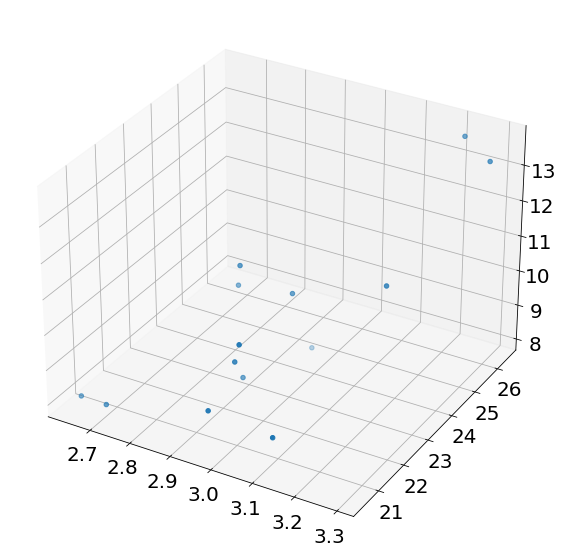

In [78]:
ax = plt.axes(projection="3d")
# ax.plot3D(xline, yline, zline, 'gray')
ax.scatter3D(
    top15Players["BayesPTS"], top15Players["BayesPER"], top15Players["BayesWS"]
);
plt.savefig("top15")

In [79]:
top15Players[
    [
        "Player",
        "SeasonsPlayed",
        "PlayerIndex",
        "BayesPTS",
        "BayesRankPTS",
        "BayesPER",
        "BayesRankPER",
        "BayesWS",
        "BayesRankWS",
    ]
]

,Player,SeasonsPlayed,PlayerIndex,BayesPTS,BayesRankPTS,BayesPER,BayesRankPER,BayesWS,BayesRankWS
390,Charles Barkley*,16,391,2.989372,16.0,23.298661,10.0,10.423682,9.0
730,Dirk Nowitzki,19,731,2.971815,18.0,21.539162,22.0,10.065762,13.0
1007,Hakeem Olajuwon*,18,1008,2.938239,21.0,22.182288,17.0,8.577876,19.0
1409,Julius Erving*,8,1410,2.948861,20.0,20.719514,29.0,8.674461,18.0
1498,Kevin Durant,10,1499,3.180687,3.0,23.898831,8.0,10.898364,7.0
1501,Kevin Garnett,23,1502,2.640774,107.0,20.565625,31.0,8.080024,26.0
1539,Kobe Bryant,20,1540,3.088203,7.0,20.979271,25.0,8.241667,21.0
1606,LeBron James,14,1607,3.218613,2.0,26.396652,3.0,13.685998,1.0
1675,Magic Johnson*,13,1676,2.885616,34.0,22.906082,14.0,11.117510,6.0
1819,Michael Jordan*,15,1820,3.291249,1.0,26.186821,4.0,13.328705,2.0


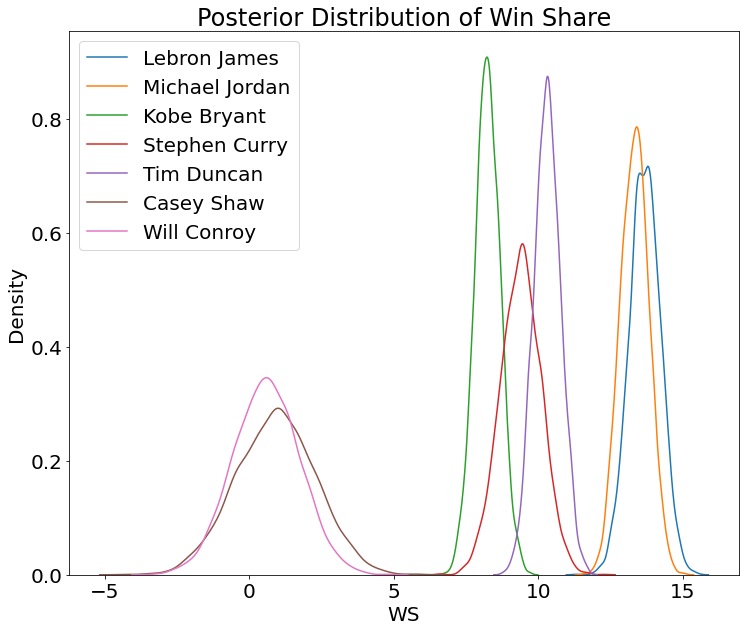

In [155]:
# Lebron James
fig = sns.distplot(
    alphaDrawsWS.query("PlayerIndex == 1607")["alpha"],
    kde=True,
    label="Lebron James",
    hist=False,
)
# Michael Jordan*
fig = sns.distplot(
    alphaDrawsWS.query("PlayerIndex == 1820")["alpha"],
    kde=True,
    label="Michael Jordan",
    hist=False,
)
# Kobe Bryant
fig = sns.distplot(
    alphaDrawsWS.query("PlayerIndex == 1540")["alpha"],
    kde=True,
    label="Kobe Bryant",
    hist=False,
)
fig = sns.distplot(
    alphaDrawsWS.query("PlayerIndex == 2394")["alpha"],
    kde=True,
    label="Stephen Curry",
    hist=False,
)
fig = sns.distplot(
    alphaDrawsWS.query("PlayerIndex == 2490")["alpha"],
    kde=True,
    label="Tim Duncan",
    hist=False,
)
fig = sns.distplot(
    alphaDrawsWS.query("PlayerIndex == 377")["alpha"],
    kde=True,
    label="Casey Shaw",
    hist=False,
)
fig = sns.distplot(
    alphaDrawsWS.query("PlayerIndex == 2677")["alpha"],
    kde=True,
    label="Will Conroy",
    hist=False,
)
plt.legend()
plt.title("Posterior Distribution of Win Share")
plt.xlabel("WS")
plt.savefig("PostiorWS")

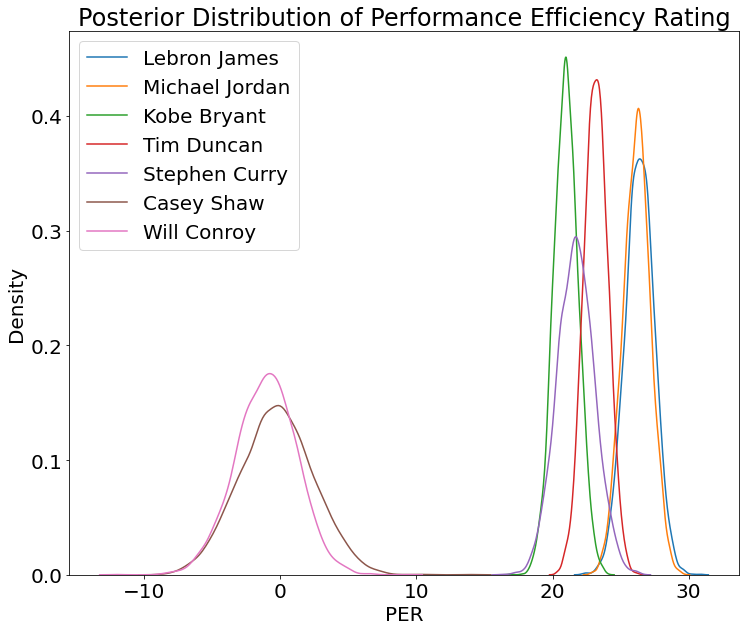

In [109]:
# Lebron James
fig = sns.distplot(
    alphaDrawsPER.query("PlayerIndex == 1607")["alpha"],
    kde=True,
    label="Lebron James",
    hist=False,
)
# Michael Jordan*
fig = sns.distplot(
    alphaDrawsPER.query("PlayerIndex == 1820")["alpha"],
    kde=True,
    label="Michael Jordan",
    hist=False,
)
# Kobe Bryant
fig = sns.distplot(
    alphaDrawsPER.query("PlayerIndex == 1540")["alpha"],
    kde=True,
    label="Kobe Bryant",
    hist=False,
)
# George Gervin
fig = sns.distplot(
    alphaDrawsPER.query("PlayerIndex == 2490")["alpha"],
    kde=True,
    label="Tim Duncan",
    hist=False,
)
fig = sns.distplot(
    alphaDrawsPER.query("PlayerIndex == 2394")["alpha"],
    kde=True,
    label="Stephen Curry",
    hist=False,
)
fig = sns.distplot(
    alphaDrawsPER.query("PlayerIndex == 377")["alpha"],
    kde=True,
    label="Casey Shaw",
    hist=False,
)
fig = sns.distplot(
    alphaDrawsPER.query("PlayerIndex == 2677")["alpha"],
    kde=True,
    label="Will Conroy",
    hist=False,
)
plt.legend(loc="upper left")
plt.title("Posterior Distribution of Performance Efficiency Rating")
plt.xlabel("PER")
plt.savefig("PosteriorPER")

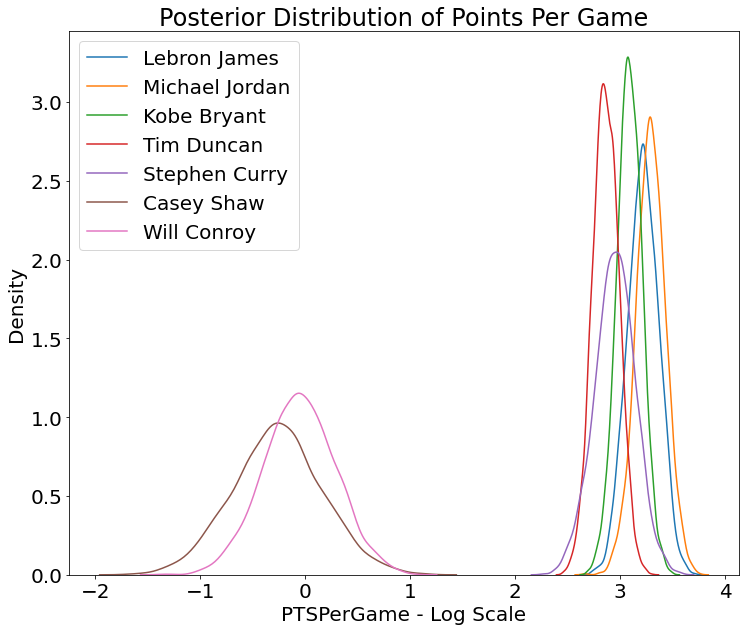

In [110]:
# Lebron James
fig = sns.distplot(
    alphaDrawsPTS.query("PlayerIndex == 1607")["alpha"],
    kde=True,
    label="Lebron James",
    hist=False,
)
# Michael Jordan*
fig = sns.distplot(
    alphaDrawsPTS.query("PlayerIndex == 1820")["alpha"],
    kde=True,
    label="Michael Jordan",
    hist=False,
)
# Kobe Bryant
fig = sns.distplot(
    alphaDrawsPTS.query("PlayerIndex == 1540")["alpha"],
    kde=True,
    label="Kobe Bryant",
    hist=False,
)
# George Gervin
fig = sns.distplot(
    alphaDrawsPTS.query("PlayerIndex == 2490")["alpha"],
    kde=True,
    label="Tim Duncan",
    hist=False,
)
fig = sns.distplot(
    alphaDrawsPTS.query("PlayerIndex == 2394")["alpha"],
    kde=True,
    label="Stephen Curry",
    hist=False,
)
fig = sns.distplot(
    alphaDrawsPTS.query("PlayerIndex == 377")["alpha"],
    kde=True,
    label="Casey Shaw",
    hist=False,
)
fig = sns.distplot(
    alphaDrawsPTS.query("PlayerIndex == 2677")["alpha"],
    kde=True,
    label="Will Conroy",
    hist=False,
)
plt.legend()
plt.title("Posterior Distribution of Points Per Game")
plt.xlabel("PTSPerGame - Log Scale")
plt.savefig("PostiorPTS")